In [1]:
from time import time
from itertools import product
import pickle as pic
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import multivariate_normal
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC

In [2]:
from cpa_utils import *

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples_full_filter\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples_full_filter\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.log"

In [4]:
seeds_total, traces_total, real_keys = load_data(traces_path, key_path)

In [5]:
EARLIEST_ROUND = 0

In [6]:
KEY_ALPHABET = list(range(16))

In [7]:
import plotly.express as px
fig = px.line(traces_total[0][0][:80000])
fig.update_layout(
    title={
        "text": "Example of trace of Elisabeth-b4's encryption",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top"
    },
    xaxis={
        "tickmode": "array",
        "tickvals": list(range(0, 80000, 80000 // 20)),
        "ticktext": [str(8*n) for n in range(20)]

    },
    xaxis_title="Time (μs)",
    yaxis_title="EM magnitude",
    showlegend=False
)
fig.show()

## Profiling stage

In [ ]:
def sost_signal_strength(seeds: np.ndarray, key: List[int], traces: np.ndarray):
    assert seeds.shape[0] == traces.shape[0]
    f = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[1]), dtype=np.float32)
    card_g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), 1), dtype=np.int32)
    m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float32)
    v = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float64)
    y = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[0]), dtype=int)

    for seed, (i, trace) in zip(seeds, enumerate(traces)):
        indices, whitening = chacha_random_b4(seed)

        for round_idx in range(EARLIEST_ROUND, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
            for block_idx in range(BLOCK_WIDTH_B4):
                keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
                real_k = (key[indices[keyround_index]] + whitening[keyround_index]) % 16
                y[round_idx, block_idx, i] = real_k
                card_g[round_idx, block_idx, real_k, 0] += 1
                m[round_idx, block_idx, real_k] += trace
                v[round_idx, block_idx, real_k] += np.square(trace.astype(np.float64))

    m /= card_g
    v = (v - card_g * m * m) / (card_g - 1)

    for i in range(len(KEY_ALPHABET)):
        for j in range(i + 1, len(KEY_ALPHABET)):
            num = m[:, :, i] - m[:, :, j]
            den = np.sqrt(v[:, :, i] / card_g[:, :, i] + v[:, :, j] / card_g[:, :, j])
            f += np.square(num / den)
    
    return f, y

def dom_signal_strength(seeds: np.ndarray, key: List[int], traces: np.ndarray):
    assert seeds.shape[0] == traces.shape[0]
    f = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[1]), dtype=np.float32)
    card_g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), 1), dtype=np.int32)
    m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float32)
    y = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[0]), dtype=int)

    for seed, (i, trace) in zip(seeds, enumerate(traces)):
        indices, whitening = chacha_random_b4(seed)

        for round_idx in range(EARLIEST_ROUND, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
            for block_idx in range(BLOCK_WIDTH_B4):
                keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
                real_k = (key[indices[keyround_index]] + whitening[keyround_index]) % 16
                y[round_idx, block_idx, i] = real_k
                card_g[round_idx, block_idx, real_k, 0] += 1
                m[round_idx, block_idx, real_k] += trace

    m /= card_g

    for i in range(len(KEY_ALPHABET)):
        for j in range(i + 1, len(KEY_ALPHABET)):
            f += m[:, :, i] - m[:, :, j]
    
    return f, y

def sost_and_dom_signal_strength(seeds: np.ndarray, key: List[int], traces: np.ndarray):
    assert seeds.shape[0] == traces.shape[0]
    f_sost = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[1]), dtype=np.float32)
    f_dom = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[1]), dtype=np.float32)
    card_g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), 1), dtype=np.int32)
    m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float32)
    v = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float64)
    y = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[0]), dtype=int)

    for seed, (i, trace) in zip(seeds, enumerate(traces)):
        indices, whitening = chacha_random_b4(seed)

        for round_idx in range(EARLIEST_ROUND, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
            for block_idx in range(BLOCK_WIDTH_B4):
                keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
                real_k = (key[indices[keyround_index]] + whitening[keyround_index]) % 16
                y[round_idx, block_idx, i] = real_k
                card_g[round_idx, block_idx, real_k, 0] += 1
                m[round_idx, block_idx, real_k] += trace
                v[round_idx, block_idx, real_k] += np.square(trace.astype(np.float64))

    m /= card_g
    v = (v - card_g * m * m) / (card_g - 1)

    for i in range(len(KEY_ALPHABET)):
        for j in range(i + 1, len(KEY_ALPHABET)):
            num = m[:, :, i] - m[:, :, j]
            den = np.sqrt(v[:, :, i] / card_g[:, :, i] + v[:, :, j] / card_g[:, :, j])

            f_sost += np.square(num / den)
            f_dom += num
    
    return f_sost, f_dom, y


In [ ]:
def n_largest_values_separated_by_cycle(f: np.ndarray, n: int, cycle_length: int) -> np.ndarray:
    interesting_points_per_index = np.zeros((f.shape[0], f.shape[1], n), dtype=int)
    sorted_strengths = np.argsort(f, axis=2)[:, :, ::-1]

    for round_idx in range(EARLIEST_ROUND, sorted_strengths.shape[0]):
        for block_idx in range(sorted_strengths.shape[1]):
            largest_indices = []
            for ind in sorted_strengths[round_idx, block_idx]:
                if len(largest_indices) < interesting_points_per_index.shape[2]:
                    if all(abs(i - ind) >= cycle_length for i in largest_indices):
                        largest_indices.append(ind)
                else:
                    break
            interesting_points_per_index[round_idx, block_idx] = np.array(largest_indices)
    
    return interesting_points_per_index

def n_largest_values(f: np.ndarray, n: int) -> np.ndarray:
    interesting_points_per_index = np.apply_along_axis(np.argpartition, axis=2, arr=f, kth=-n)[:, :, -n:]
    return interesting_points_per_index

### Choosing one point per clock cycle

Arduino Due: 84 MHz
Sampling rate: 2.5 GHz

In [6]:
SAMPLES_PER_CYCLE = int(2500 / 84)
SAMPLES_PER_CYCLE

29

29 points per cycle

## Extraction stage

In [ ]:
def recover_key_count_best(classifications_scores: np.ndarray, target_seeds: np.ndarray):
    classifications_best = np.argmax(classifications_scores, axis=-1)

    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=int)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                classifications_per_key_nibble[key_index, (classifications_best[round_idx, block_idx][i] - whitening[keyround_index]) % 16] += 1
    recovered_key = np.argmax(classifications_per_key_nibble, axis=1) # Majority voting
    return recovered_key

In [ ]:
def recover_key_sum_probs_rank(classifications_scores: np.ndarray, target_seeds: np.ndarray):
    classifications_ranks = np.apply_along_axis(lambda a: np.searchsorted(np.sort(-a), -a), axis=-1, arr=classifications_scores)

    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=int)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                classifications_per_key_nibble[key_index] += np.roll(classifications_ranks[round_idx, block_idx, i], -whitening[keyround_index])
    recovered_key = np.argmin(classifications_per_key_nibble, axis=1)
    return recovered_key

In [ ]:
def recover_key_multiply_probs(classifications_scores: np.ndarray, target_seeds: np.ndarray):
    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=np.longdouble)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                classifications_per_key_nibble[key_index] += np.roll(classifications_scores[round_idx, block_idx, i], -whitening[keyround_index])
    recovered_key = np.argmax(classifications_per_key_nibble, axis=1)
    return recovered_key

In [13]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [500, 750, 1_000]

with open("template_precomputed_pics/trainval_test_split_f_y_sost_3.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval_tot, y_trainval_tot = pic.load(r)

grid = {"num_features": [20, 40, 60]}

In [ ]:
best_accuracy = -1
grid_results = np.zeros((len(grid["num_features"]), len(train_sizes), len(val_size_grid), f_trainval_tot.shape[1], n_folds), dtype=np.float64)
for l, num_features in enumerate(grid["num_features"]):
    for ts, train_size in enumerate(train_sizes):
        f_trainval_methods = f_trainval_tot[ts]
        y_trainval = y_trainval_tot[ts]

        for m, val_size in enumerate(val_size_grid):
            rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
            times = np.zeros((2, f_trainval_methods.shape[0], n_folds), dtype=np.float64)
            for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval[ts])):
                print(f"CV {cv}", end="\r")
                traces_train, traces_val = traces_trainval[ts][train_index], traces_trainval[ts][val_index]
                seeds_train, seeds_val = seeds_trainval[ts][train_index], seeds_trainval[ts][val_index]
                y = y_trainval[m, cv]

                for n, f_trainval in enumerate(f_trainval_methods):
                    f = f_trainval[m, cv]

                    interesting_points_per_index = n_largest_values(f, num_features)
                    traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)
                    traces_val_reduced = traces_val[:, interesting_points_per_index].transpose(1, 2, 0, 3)

                    traces_reduced_per_key = [[[traces_reduced[round_idx, block_idx, np.repeat((y == k)[round_idx, block_idx, :, np.newaxis], traces_reduced.shape[-1], axis=-1)].reshape(-1, traces_reduced.shape[-1]) for k in range(len(KEY_ALPHABET))] for block_idx in range(traces_reduced.shape[1])] for round_idx in range(traces_reduced.shape[0])]

                    start = time()
                    template_means = np.array([[[np.mean(traces_reduced_per_key[round_idx][block_idx][k], axis=-2) for k in range(len(KEY_ALPHABET))] for block_idx in range(traces_reduced.shape[1])] for round_idx in range(traces_reduced.shape[0])])
                    template_covariances = np.array([[[np.nan_to_num(np.cov(traces_reduced_per_key[round_idx][block_idx][k], rowvar=False), nan=0.0) for k in range(template_means.shape[2])] for block_idx in range(template_means.shape[1])] for round_idx in range(template_means.shape[0])])
                    pdfs = np.array([[[multivariate_normal(template_means[round_idx, block_idx, k], template_covariances[round_idx, block_idx, k], allow_singular=True) for k in range(template_means.shape[2])] for block_idx in range(template_means.shape[1])] for round_idx in range(template_means.shape[0])])
                    times[0, n, cv] = time() - start
                    

                    start = time()
                    val_probas = np.array([[[[pdfs[round_idx, block_idx, key_guess].logpdf(traces_val_reduced[round_idx, block_idx, trace]) for key_guess in range(pdfs.shape[2])] for trace in range(traces_val_reduced.shape[2])] for block_idx in range(pdfs.shape[1])] for round_idx in range(pdfs.shape[0])])
                    recovered_key = recover_key_multiply_probs(val_probas, seeds_val)
                    times[1, n, cv] = time() - start

                    grid_results[l, ts, m, n, cv] = np.count_nonzero(recovered_key == real_keys[0]) / KEY_WIDTH_B4
                
            print(f"SOST [num features: {num_features}, train size: {train_size}, val size: {val_size}]: {np.mean(grid_results[l, ts, m, 0]):#.4g} ± {np.std(grid_results[l, ts, m, 0]):#.4g} ({grid_results[l, ts, m, 0]}). Training in {np.mean(times[0, 0]):#.4g} ± {np.std(times[0, 0]):#.4g} seconds. Extracting in {np.mean(times[1, 0]):#.4g} ± {np.std(times[1, 0]):#.4g} seconds.")
            if np.mean(grid_results[l, ts, m, 0]) > best_accuracy:
                print("New best model found ! (Above)")
                best_accuracy = np.mean(grid_results[l, ts, m, 0])


## Using Machine Learning

### Training

In [8]:
def train_models(classifier: ClassifierMixin, traces_reduced: np.ndarray, y: np.ndarray, **kwargs):
    models = np.empty(traces_reduced.shape[:2], dtype=object)
    for round_idx in range(EARLIEST_ROUND, models.shape[0]):
        for block_idx in range(models.shape[1]):
            clf = classifier(**kwargs)
            clf.fit(traces_reduced[round_idx, block_idx], y[round_idx, block_idx])
            models[round_idx, block_idx] = clf

    return models

### Parameter tuning

In [13]:
n_folds = 5
train_size = 100_000
val_size_grid = [1_000, 2_000, 5_000]
with open("template_precomputed_pics/trainval_test_split_f_y_sost.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval, y_trainval = pic.load(r)


In [26]:
n_folds = 5
train_size = 60_000
val_size_grid = [750, 1_000, 1_500]

with open("template_precomputed_pics/trainval_test_split_f_y_sost_2.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval, y_trainval = pic.load(r)


In [ ]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [500, 750, 1_000]

with open("template_precomputed_pics/trainval_test_split_f_y_sost_3.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval_tot, y_trainval_tot = pic.load(r)


In [3]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [1_500, 2_000, 2_500]

with open("template_precomputed_pics/trainval_test_split_f_y_sost_4.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval_tot, y_trainval_tot = pic.load(r)


In [4]:
f_trainval_tot.shape

(2, 1, 3, 5, 14, 7, 100000)

In [ ]:
import plotly.express as px

px.line(f_trainval_tot[0, 0, 0, 0, 0, 0])

In [19]:
traces_trainval, traces_test, seeds_trainval, seeds_test = train_test_split(traces_total[0], seeds_total[0], train_size=train_size + max(val_size_grid), random_state=0)
f_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces_trainval.shape[1]), dtype=np.float32)
y_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, train_size), dtype=np.int32)

for m, val_size in enumerate(val_size_grid):
    rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
    for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval)):
        traces_train, seeds_train = traces_trainval[train_index], seeds_trainval[train_index]
        f, y = sost_signal_strength(seeds_train, real_keys[0], traces_train)
        f_trainval[m, cv] = f
        y_trainval[m, cv] = y

In [13]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [500, 750, 1_000]

In [13]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [1_500, 2_000, 2_500]

In [14]:
traces_trainval, traces_test, seeds_trainval, seeds_test = [], [], [], []
f_trainval_tot = np.zeros((len(train_sizes), 1, len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces_total[0].shape[1]), dtype=np.float32)
y_trainval_tot = []
for ts, train_size in enumerate(train_sizes):
    y_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, train_size), dtype=np.int32)

    s = train_test_split(traces_total[0], seeds_total[0], train_size=train_size + max(val_size_grid), random_state=0)
    traces_trainval.append(s[0]), traces_test.append(s[1]), seeds_trainval.append(s[2]), seeds_test.append(s[3])

    for m, val_size in enumerate(val_size_grid):
        rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
        for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval[ts])):
            traces_train, seeds_train = traces_trainval[ts][train_index], seeds_trainval[ts][train_index]
            f, y = sost_signal_strength(seeds_train, real_keys[0], traces_train)
            f_trainval_tot[ts, 0, m, cv] = f
            y_trainval[m, cv] = y
    y_trainval_tot.append(y_trainval)

In [15]:
with open("template_precomputed_pics/trainval_test_split_f_y_sost_4.pic", "wb") as w:
    pic.dump((traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval_tot, y_trainval_tot), w)


In [16]:
params_grid = [
    {
        "estimator": HistGradientBoostingClassifier,
        "num_features": [60],
        "model_params": {
            "max_iter": [300],
            "max_depth": [None],
            "min_samples_leaf": [6]
        }
    },
    # {
    #     "estimator": RandomForestClassifier,
    #     "num_features": [60],
    #     "model_params": {
    #         "n_estimators": [300],
    #         "max_depth": [None],
    #         "min_samples_leaf": [6, 8, 10]
    #     }
    # },
    # {
    #     "estimator": LinearSVC,
    #     "num_features": [60],
    #     "model_params": {
    #         "loss": ["hinge"],
    #         "C": [1, 10],
    #     }
    # },
    # {
    #     "estimator": SVC,
    #     "num_features": [20, 40, 60],
    #     "model_params": {
    #         "decision_function_shape": ["ovr"],
    #         "kernel": ["rbf"],
    #         "C": [0.1, 1, 10],
    #         "gamma": ["scale", "auto"]
    #     }
    # },
    # {
    #     "estimator": SVC,
    #     "num_features": [20, 40, 60],
    #     "model_params": {
    #         "decision_function_shape": ["ovr"],
    #         "kernel": ["poly"],
    #         "C": [0.1, 1, 10],
    #         "degree": [3, 5, 7]
    #     }
    # },
]

best_params = {}
best_accuracy = -1

for grid in params_grid:
    param_combinations = list(product(*grid["model_params"].values()))
    grid_results = np.zeros((len(param_combinations), len(grid["num_features"]), len(train_sizes), len(val_size_grid), f_trainval_tot.shape[1], n_folds), dtype=np.float64)
    for combination_index, params in enumerate(param_combinations):
        model_params_dict = dict(zip(grid["model_params"].keys(), params))
        for l, num_features in enumerate(grid["num_features"]):
            for ts, train_size in enumerate(train_sizes):
                f_trainval_methods = f_trainval_tot[ts]
                y_trainval = y_trainval_tot[ts]

                for m, val_size in enumerate(val_size_grid):
                    rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
                    times = np.zeros((f_trainval_methods.shape[0], n_folds), dtype=np.float64)
                    for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval[ts])):
                        print(f"CV {cv}", end="\r")
                        traces_train, traces_val = traces_trainval[ts][train_index], traces_trainval[ts][val_index]
                        seeds_train, seeds_val = seeds_trainval[ts][train_index], seeds_trainval[ts][val_index]
                        y = y_trainval[m, cv]

                        for n, f_trainval in enumerate(f_trainval_methods):
                            f = f_trainval[m, cv]

                            interesting_points_per_index = n_largest_values(f, num_features)
                            traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)
                            traces_val_reduced = traces_val[:, interesting_points_per_index].transpose(1, 2, 0, 3)

                            start = time()
                            models = train_models(grid["estimator"], traces_reduced, y, **model_params_dict, random_state=0)
                            times[n, cv] = time() - start
                            classifications_scores = np.array([[np.log(mod.predict_proba(traces_val_reduced[round_idx, block_idx])) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, mod in enumerate(row)] for round_idx, row in enumerate(models)])

                            recovered_key = recover_key_multiply_probs(classifications_scores, seeds_val)

                            grid_results[combination_index, l, ts, m, n, cv] = np.count_nonzero(recovered_key == real_keys[0]) / KEY_WIDTH_B4
                        
                    print(f"SOST [{model_params_dict}, num features: {num_features}, train size: {train_size}, val size: {val_size}]: {np.mean(grid_results[combination_index, l, ts, m, 0]):#.4g} ± {np.std(grid_results[combination_index, l, ts, m, 0]):#.4g} ({grid_results[combination_index, l, ts, m, 0]}). Training in {np.mean(times[0]):#.4g} ± {np.std(times[0]):#.4g} seconds.")
                    if np.mean(grid_results[combination_index, l, ts, m, 0]) > best_accuracy:
                        print("New best model found ! (Above)")
                        best_accuracy = np.mean(grid_results[combination_index, l, ts, m, 0])

                    #print(f" DOM [{model_params_dict}, num features: {num_features}, train size: {train_size}, val size: {val_size}]: {np.mean(grid_results[combination_index, l, ts, m, 1]):#.4g} ± {np.std(grid_results[combination_index, l, ts, m, 1]):#.4g} ({grid_results[combination_index, l, ts, m, 1]}). Training in {np.mean(times[1]):#.4g} ± {np.std(times[1]):#.4g} seconds.")
                    #if np.mean(grid_results[combination_index, l, ts, m, 1]) > best_accuracy:
                    #    print("New best model found ! (Above)")
                    #    best_accuracy = np.mean(grid_results[combination_index, l, ts, m, 1])

SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 60000, val size: 1500]: 0.9949 ± 0.0009568 ([0.99609375 0.99414062 0.99414062 0.99609375 0.99414062]). Training in 436.8 ± 33.17 seconds.
New best model found ! (Above)
SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 60000, val size: 2000]: 0.9992 ± 0.0009568 ([0.99804688 1.         1.         0.99804688 1.        ]). Training in 474.2 ± 11.23 seconds.
New best model found ! (Above)
SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 60000, val size: 2500]: 1.000 ± 0.000 ([1. 1. 1. 1. 1.]). Training in 487.4 ± 8.411 seconds.
New best model found ! (Above)
SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 100000, val size: 1500]: 0.9996 ± 0.0007813 ([1.         1.         1.         1.         0.99804688]). Training in 1236. ± 97.10 seconds.
SOST [{'max

### Accuracy on unseen data

Retraining on all available data

In [36]:

rs = ShuffleSplit(n_splits=5, test_size=1_500, train_size=100_000, random_state=0)
train_index, _ = next(rs.split(traces_trainval[1]))
traces_train, seeds_train = traces_trainval[1][train_index], seeds_trainval[1][train_index]

y = y_trainval_tot[1][0][0]
f = f_trainval_tot[1, 0, 0, 0]

interesting_points_per_index = n_largest_values(f, grid["num_features"])
traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)

traces_reduced_per_key = [[[traces_reduced[round_idx, block_idx, np.repeat((y == k)[round_idx, block_idx, :, np.newaxis], traces_reduced.shape[-1], axis=-1)].reshape(-1, traces_reduced.shape[-1]) for k in range(len(KEY_ALPHABET))] for block_idx in range(traces_reduced.shape[1])] for round_idx in range(traces_reduced.shape[0])]
template_means = np.array([[[np.mean(traces_reduced_per_key[round_idx][block_idx][k], axis=-2) for k in range(len(KEY_ALPHABET))] for block_idx in range(traces_reduced.shape[1])] for round_idx in range(traces_reduced.shape[0])])
template_covariances = np.array([[[np.nan_to_num(np.cov(traces_reduced_per_key[round_idx][block_idx][k], rowvar=False), nan=0.0) for k in range(template_means.shape[2])] for block_idx in range(template_means.shape[1])] for round_idx in range(template_means.shape[0])])
pdfs = np.array([[[multivariate_normal(template_means[round_idx, block_idx, k], template_covariances[round_idx, block_idx, k], allow_singular=True) for k in range(template_means.shape[2])] for block_idx in range(template_means.shape[1])] for round_idx in range(template_means.shape[0])])

In [37]:
traces_test_reduced = traces_test[1][:, interesting_points_per_index].transpose(1, 2, 0, 3)
classifications_scores = np.array([[[[pdfs[round_idx, block_idx, key_guess].logpdf(traces_test_reduced[round_idx, block_idx, trace]) for key_guess in range(pdfs.shape[2])] for trace in range(traces_test_reduced.shape[2])] for block_idx in range(pdfs.shape[1])] for round_idx in range(pdfs.shape[0])])

In [38]:
per_trace_total = np.zeros((seeds_test[1].shape[0], KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=np.float64)
sums = np.zeros(KEY_WIDTH_B4, dtype=int)
counts = np.zeros(KEY_WIDTH_B4, dtype=int)
for i, seed in enumerate(seeds_test[1]):
    indices, whitening = chacha_random_b4(seed)
    for keyround_index in range(KEYROUND_WIDTH_B4):
        key_index = indices[keyround_index]
        round_idx = keyround_index // BLOCK_WIDTH_B4
        block_idx = keyround_index % BLOCK_WIDTH_B4

        if round_idx >= EARLIEST_ROUND:
            per_trace_total[i, key_index] += np.roll(classifications_scores[round_idx, block_idx, i], -whitening[keyround_index])
            sums[key_index] += np.argmax(per_trace_total[i, key_index]) == real_keys[0][key_index]
            counts[key_index] += 1
accuracies = sums / counts

In [39]:
np.mean(accuracies), np.std(accuracies)

(0.1332951474083173, 0.0020246430151252513)

In [40]:
def guessing_entropy(classifications_per_key_nibble: np.ndarray, key: np.ndarray):
    return np.argmax(np.argsort(classifications_per_key_nibble, axis=-1)[..., ::-1] == key[..., np.newaxis], axis=-1)

def compute_mean_ranks(per_trace: np.ndarray, key: np.ndarray, max_size=None, bins=10, repeat=500):
    if max_size is None:
        max_size = per_trace.shape[0]
    mean_ranks = np.zeros((per_trace.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * max_size // bins

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace.shape[1], dtype=int)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
            rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks
MAX_SIZE = 1_000
mean_ranks = compute_mean_ranks(per_trace_total, real_keys[0], max_size=MAX_SIZE, repeat=100)

0
19
29
39
49
59
69
79
89
99


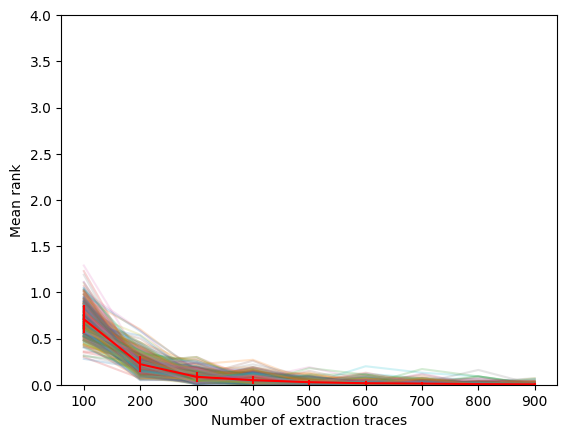

In [41]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot([i * MAX_SIZE // 10 for i in range(10)][1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar([i * MAX_SIZE // 10 for i in range(10)][1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
#plt.xscale("log")
#plt.title("GE graph with 20 neural networks (750'000 profiling traces)")
plt.xlabel("Number of extraction traces")
plt.ylabel("Mean rank")
plt.ylim([0, 4])
#plt.legend()
plt.show()

In [11]:
grid = {
    "estimator": RandomForestClassifier,
    "num_features": 40,
    "model_params": {
        "n_estimators": 300,
        "max_depth": None,
        "min_samples_leaf": 6,
        "n_jobs": -1
    }
}

rs = ShuffleSplit(n_splits=5, test_size=1_500, train_size=100_000, random_state=0)
train_index, _ = next(rs.split(traces_trainval[1]))
traces_train, seeds_train = traces_trainval[1][train_index], seeds_trainval[1][train_index]

y = y_trainval_tot[1][0][0]
f = f_trainval_tot[1, 0, 0, 0]

interesting_points_per_index = n_largest_values(f, grid["num_features"])
traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)

models = train_models(grid["estimator"], traces_reduced, y, **grid["model_params"], random_state=0)

In [12]:
traces_test_reduced = traces_test[1][:, interesting_points_per_index].transpose(1, 2, 0, 3)

classifications_scores = np.array([[np.log(mod.predict_proba(traces_test_reduced[round_idx, block_idx])) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, mod in enumerate(row)] for round_idx, row in enumerate(models)])

In [13]:
per_trace_total = np.zeros((seeds_test[1].shape[0], KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=np.float64)
sums = np.zeros(KEY_WIDTH_B4, dtype=int)
counts = np.zeros(KEY_WIDTH_B4, dtype=int)
for i, seed in enumerate(seeds_test[1]):
    indices, whitening = chacha_random_b4(seed)
    for keyround_index in range(KEYROUND_WIDTH_B4):
        key_index = indices[keyround_index]
        round_idx = keyround_index // BLOCK_WIDTH_B4
        block_idx = keyround_index % BLOCK_WIDTH_B4

        if round_idx >= EARLIEST_ROUND:
            per_trace_total[i, key_index] += np.roll(classifications_scores[round_idx, block_idx, i], -whitening[keyround_index])
            sums[key_index] += np.argmax(per_trace_total[i, key_index]) == real_keys[0][key_index]
            counts[key_index] += 1
accuracies = sums / counts

In [14]:
np.mean(accuracies), np.std(accuracies)

(0.1092574543855537, 0.0017175285996492435)

In [15]:
def guessing_entropy(classifications_per_key_nibble: np.ndarray, key: np.ndarray):
    return np.argmax(np.argsort(classifications_per_key_nibble, axis=-1)[..., ::-1] == key[..., np.newaxis], axis=-1)

def compute_mean_ranks(per_trace: np.ndarray, key: np.ndarray, max_size=None, bins=10, repeat=500):
    if max_size is None:
        max_size = per_trace.shape[0]
    mean_ranks = np.zeros((per_trace.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * max_size // bins

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace.shape[1], dtype=int)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
            rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks
MAX_SIZE = 1_000
mean_ranks = compute_mean_ranks(per_trace_total, real_keys[0], max_size=MAX_SIZE, repeat=100)

0
19
29
39
49
59
69
79
89
99


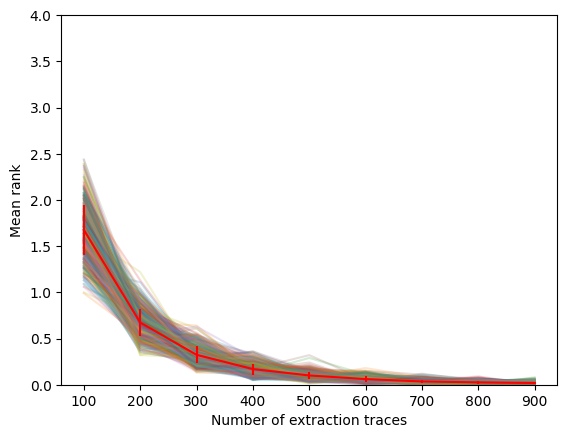

In [16]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot([i * MAX_SIZE // 10 for i in range(10)][1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar([i * MAX_SIZE // 10 for i in range(10)][1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
#plt.xscale("log")
#plt.title("GE graph with 20 neural networks (750'000 profiling traces)")
plt.xlabel("Number of extraction traces")
plt.ylabel("Mean rank")
plt.ylim([0, 4])
#plt.legend()
plt.show()

In [ ]:
grid = {
    "estimator": HistGradientBoostingClassifier,
    "num_features": 60,
    "model_params": {
        "max_iter": 300,
        "max_depth": None,
        "min_samples_leaf": 6
    }
}

rs = ShuffleSplit(n_splits=5, test_size=1_500, train_size=100_000, random_state=0)
train_index, _ = next(rs.split(traces_trainval[1]))
traces_train, seeds_train = traces_trainval[1][train_index], seeds_trainval[1][train_index]

y = y_trainval_tot[1][0][0]
f = f_trainval_tot[1, 0, 0, 0]

interesting_points_per_index = n_largest_values(f, grid["num_features"])
traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)

models = train_models(grid["estimator"], traces_reduced, y, **grid["model_params"], random_state=0)

In [12]:
traces_test_reduced = traces_test[1][:, interesting_points_per_index].transpose(1, 2, 0, 3)

classifications_scores = np.array([[np.log(mod.predict_proba(traces_test_reduced[round_idx, block_idx])) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, mod in enumerate(row)] for round_idx, row in enumerate(models)])

In [23]:
per_trace_total = np.zeros((seeds_test[1].shape[0], KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=np.float64)
sums = np.zeros(KEY_WIDTH_B4, dtype=int)
counts = np.zeros(KEY_WIDTH_B4, dtype=int)
for i, seed in enumerate(seeds_test[1]):
    indices, whitening = chacha_random_b4(seed)
    for keyround_index in range(KEYROUND_WIDTH_B4):
        key_index = indices[keyround_index]
        round_idx = keyround_index // BLOCK_WIDTH_B4
        block_idx = keyround_index % BLOCK_WIDTH_B4

        if round_idx >= EARLIEST_ROUND:
            per_trace_total[i, key_index] += np.roll(classifications_scores[round_idx, block_idx, i], -whitening[keyround_index])
            sums[key_index] += np.argmax(per_trace_total[i, key_index]) == real_keys[0][key_index]
            counts[key_index] += 1
accuracies = sums / counts

In [25]:
np.mean(accuracies), np.std(accuracies)

(0.11135934818423174, 0.0017988529087666007)

In [34]:
def guessing_entropy(classifications_per_key_nibble: np.ndarray, key: np.ndarray):
    return np.argmax(np.argsort(classifications_per_key_nibble, axis=-1)[..., ::-1] == key[..., np.newaxis], axis=-1)

def compute_mean_ranks(per_trace: np.ndarray, key: np.ndarray, max_size=None, bins=10, repeat=500):
    if max_size is None:
        max_size = per_trace.shape[0]
    mean_ranks = np.zeros((per_trace.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * max_size // bins

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace.shape[1], dtype=int)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
            rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks
MAX_SIZE = 1_000
mean_ranks = compute_mean_ranks(per_trace_total, real_keys[0], max_size=MAX_SIZE, repeat=100)

0
19
29
39
49
59
69
79
89
99


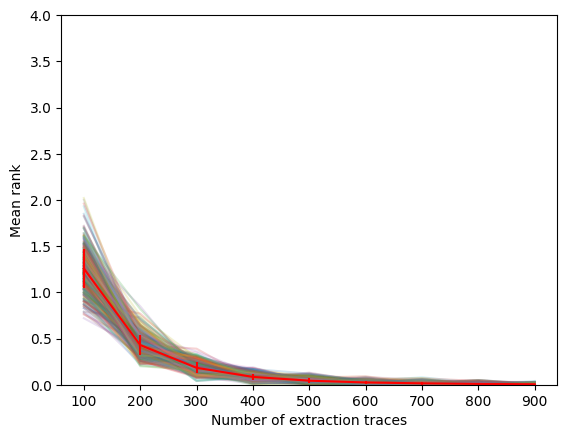

In [35]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot([i * MAX_SIZE // 10 for i in range(10)][1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar([i * MAX_SIZE // 10 for i in range(10)][1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
#plt.xscale("log")
#plt.title("GE graph with 20 neural networks (750'000 profiling traces)")
plt.xlabel("Number of extraction traces")
plt.ylabel("Mean rank")
plt.ylim([0, 4])
#plt.legend()
plt.show()

On test data

In [24]:
best_params = {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 6, 'num_features': 40, 'test_size': 1500}
with open("template_precomputed_pics/f_y_entire_train.pic", "rb") as r:
    f, y = pic.load(r)
interesting_points_per_index = n_largest_values(f, best_params["num_features"])
traces_reduced = traces_trainval[:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_test_reduced = traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3)

random_forests = train_models(RandomForestClassifier, traces_reduced, y, n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], min_samples_leaf=best_params["min_samples_leaf"], n_jobs=-1, random_state=0)

In [76]:
best_params

{'n_estimators': 200,
 'max_depth': None,
 'min_samples_leaf': 6,
 'num_features': 40,
 'test_size': 1500}

In [66]:
f, y = sost_signal_strength(seeds_trainval, real_keys[0], traces_trainval)
interesting_points_per_index = n_largest_values(f, best_params["num_features"])
traces_reduced = traces_trainval[:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_test_reduced = traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3)

random_forests = train_models(RandomForestClassifier, traces_reduced, y, n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], min_samples_leaf=best_params["min_samples_leaf"], n_jobs=-1, random_state=0)

In [69]:
with open("template_precomputed_pics/f_y_entire_train.pic", "wb") as w:
    pic.dump((f, y), w)


In [ ]:
print(f"Train parameters: { {k: v for k, v in best_params.items() if k != 'test_size'} }")
for test_size in [1_000, 1_500, 2_500, 5_000]:
    print(f"Test size {test_size}")
    sub_tests = np.zeros((traces_test_reduced.shape[2] // test_size, test_size), dtype=int)
    available_indices = np.arange(traces_test_reduced.shape[2])

    np.random.seed(test_size)
    for i in range(sub_tests.shape[0]):
        sub_tests[i] = np.random.choice(available_indices, test_size, replace=False)
        available_indices = np.setdiff1d(available_indices, sub_tests[i])
        
    accuracies = np.zeros((sub_tests.shape[0], 3), np.float64)
    for i, sub_test in enumerate(sub_tests):
        sub_traces, sub_seeds = traces_test_reduced[:, :, sub_test], seeds_test[sub_test]
        classifications_scores = np.array([[rfc.predict_log_proba(sub_traces[round_idx, block_idx]) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, rfc in enumerate(rfs)] for round_idx, rfs in enumerate(random_forests)])

        accuracies[i, 0] = np.count_nonzero(recover_key_count_best(classifications_scores, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
        accuracies[i, 1] = np.count_nonzero(recover_key_sum_probs_rank(classifications_scores, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
        accuracies[i, 2] = np.count_nonzero(recover_key_multiply_probs(classifications_scores, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
    
        print(f"{i}/{len(sub_tests)}: {accuracies[i, 0]} -> {accuracies[i, 1]} -> {accuracies[i, 2]}")
    mean_acc = np.mean(accuracies, axis=0)
    std_acc  = np.std(accuracies, axis=0)

    print(f"Test size [{test_size}]. Expected accuracy on unseen data: {mean_acc[0]} ± {std_acc[0]} -> {mean_acc[1]} ± {std_acc[1]} -> {mean_acc[2]} ± {std_acc[2]}")

In [ ]:
traces_test_path_1 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-4_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.mat"
key_test_path_1 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-4_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.log"
traces_test_path_2 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-12_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_test_path_2 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-12_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"

seeds_test_1, traces_test_1, real_keys_1 = load_data(traces_test_path_1, key_test_path_1)
seeds_test_2, traces_test_2, real_keys_2 = load_data(traces_test_path_2, key_test_path_2)

seeds_test_multiple_keys, traces_test_multiple_keys, real_keys_multiple_keys = seeds_test_1 + seeds_test_2, traces_test_1 + traces_test_2, real_keys_1 + real_keys_2
del seeds_test_1, seeds_test_2, traces_test_1, traces_test_2, real_keys_1, real_keys_2

In [25]:
traces_test_reduced_multiple_keys = [traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3) for traces_test in traces_test_multiple_keys]

In [ ]:
print(f"Train parameters: { {k: v for k, v in best_params.items() if k != 'test_size'} }")
for k, (seeds_test, traces_test_reduced, real_keys) in enumerate(zip(seeds_test_multiple_keys, traces_test_reduced_multiple_keys, real_keys_multiple_keys)):
    print(f"Key {k}")
    for test_size in [1_000, 1_500, 2_500]:
        print(f"Test size {test_size}")
        sub_tests = np.zeros((traces_test_reduced.shape[2] // test_size, test_size), dtype=int)
        available_indices = np.arange(traces_test_reduced.shape[2])

        np.random.seed(test_size)
        for i in range(sub_tests.shape[0]):
            sub_tests[i] = np.random.choice(available_indices, test_size, replace=False)
            available_indices = np.setdiff1d(available_indices, sub_tests[i])
            
        accuracies = np.zeros((sub_tests.shape[0], 3), np.float64)
        for i, sub_test in enumerate(sub_tests):
            sub_traces, sub_seeds = traces_test_reduced[:, :, sub_test], seeds_test[sub_test]
            classifications_scores = np.array([[rfc.predict_log_proba(sub_traces[round_idx, block_idx]) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, rfc in enumerate(rfs)] for round_idx, rfs in enumerate(random_forests)])

            accuracies[i, 0] = np.count_nonzero(recover_key_count_best(classifications_scores, sub_seeds) == real_keys) / KEY_WIDTH_B4
            accuracies[i, 1] = np.count_nonzero(recover_key_sum_probs_rank(classifications_scores, sub_seeds) == real_keys) / KEY_WIDTH_B4
            accuracies[i, 2] = np.count_nonzero(recover_key_multiply_probs(classifications_scores, sub_seeds) == real_keys) / KEY_WIDTH_B4
        
            print(f"{i}/{len(sub_tests)}: {accuracies[i, 0]} -> {accuracies[i, 1]} -> {accuracies[i, 2]}")
        mean_acc = np.mean(accuracies, axis=0)
        std_acc  = np.std(accuracies, axis=0)

        print(f"Test size [{test_size}]. Expected accuracy on unseen data: {mean_acc[0]} ± {std_acc[0]} -> {mean_acc[1]} ± {std_acc[1]} -> {mean_acc[2]} ± {std_acc[2]}")

#### Error analysis

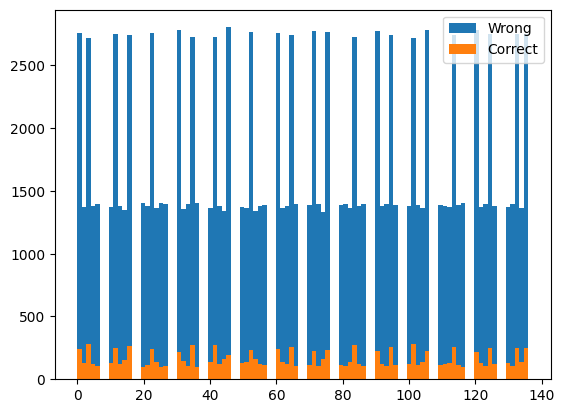

In [44]:
errors = []
corrects = []
for round_idx, rfs in enumerate(random_forests):
    for block_idx, rfc in enumerate(rfs):
        keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
        classifications_scores = rfc.predict(traces_test_reduced[round_idx, block_idx])
        for i, seed in enumerate(seeds_test):
            indices, whitening = chacha_random_b4(seed)
            key_index = indices[keyround_index]
            if (classifications_scores[i] - whitening[keyround_index]) % 16 != real_keys[0][key_index]:
                errors.append((round_idx, block_idx))
            else:
                corrects.append((round_idx, block_idx))
plt.hist([10 * r + b for r, b in errors], bins=100, label="Wrong")
plt.hist([10 * r + b for r, b in corrects], bins=100, label="Correct")
plt.legend()
plt.show()